# SDWFS AGN Surface Density--Color Trend Plot
## Author: Benjamin Floyd

Generates a pubication plot of the AGN surface density as a function of the purity color selection threshold.

In [1]:
import json

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 14})

In [2]:
# Read in data file
with open('Data_Repository/Project_Data/SPT-IRAGN/SDWFS_background/SDWFS_background_prior_distributions_mu_cut.json', 'r') as f:
    agn_surf_den_data = json.load(f)
agn_surf_den = agn_surf_den_data['agn_surf_den']
agn_surf_den_uerr = agn_surf_den_data['agn_surf_den_uerr']
agn_surf_den_lerr = agn_surf_den_data['agn_surf_den_lerr']
color_thresholds = agn_surf_den_data['color_thresholds']

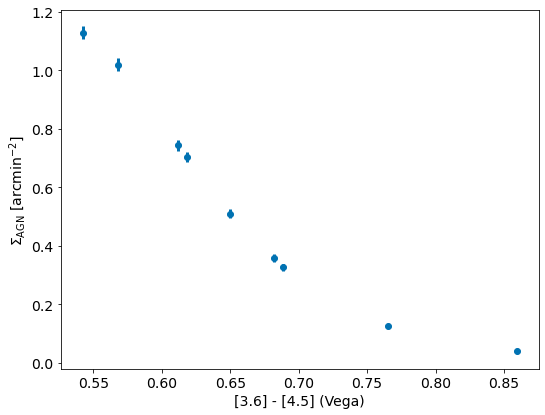

In [23]:
# Create plot
fig, ax = plt.subplots(figsize=(7.8, 6))
ax.errorbar(color_thresholds[:-1], agn_surf_den, yerr=(agn_surf_den_lerr, agn_surf_den_uerr), fmt='o', elinewidth=3)
ax.set(xlabel='[3.6] - [4.5] (Vega)', ylabel=r'$\Sigma_{\mathrm{AGN}}$ [arcmin$^{-2}$]')
fig.tight_layout()
fig.savefig('Data_Repository/Project_Data/SPT-IRAGN/Publication_Plots/SDWFS_AGN_surfden-color_threshold_publication_mu_cut.pdf')